In [1]:
import sys
print(sys.executable)
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os
from time import time
import pandas as pd
from glob import glob
from KerasOCRTrainer2 import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, optimizers
from tensorflow import keras
from tensorflow.keras.layers import Lambda
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

/Users/eduard/.pyenv/versions/3.6.8/envs/keras36/bin/python


/Users/eduard/.pyenv/versions/3.6.8/envs/keras36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/eduard/.pyenv/versions/3.6.8/envs/keras36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/eduard/.pyenv/versions/3.6.8/envs/keras36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Use

/Users/eduard/.pyenv/versions/3.6.8/envs/keras36/bin/python


# Create df to flow from

In [2]:
# ubuntu
#file_list = glob('/home/eduard/workspace/VitmoOCR/vitmo_video_data/data/*/*.png')
# mac
file_list = glob('/Users/eduard/workspaces/ml_projects/keras/VitmoOCR/data/*/*.png')
df_lst = []
for file_path in file_list:
    label = file_path.split('/')[-2]
    alt_label = label
    while len(alt_label)<3:
        alt_label = ' '+alt_label
    if alt_label == 'nan':
        alt_label = '   '
        
    l0,l1,l2 = alt_label
    
    df_lst.append({
        'file_path': file_path,
        'single_label':label,
        'multi_label':np.array([l0,l1,l2]),
        'l0':str(l0),
        'l1':str(l1),
        'l2':str(l2),
#         'splitable':f'{l0},{l1},{l2}'
    }
    )
    
df = pd.DataFrame(df_lst)

In [3]:
def one_hot(cat):
    categories = [' ','0','1','2','3','4','5','6','7','8','9']
    return (cat==np.array(categories) ).astype(int).tolist()

categories = [' ','0','1','2','3','4','5','6','7','8','9']
for col in ['l0','l1','l2']:
    df[col+'d'] = df[col].apply(one_hot)
df.head()

,file_path,single_label,multi_label,l0,l1,l2,l0d,l1d,l2d
0,/Users/eduard/workspaces/ml_projects/keras/Vit...,135,"[1, 3, 5]",1,3,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
1,/Users/eduard/workspaces/ml_projects/keras/Vit...,135,"[1, 3, 5]",1,3,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,/Users/eduard/workspaces/ml_projects/keras/Vit...,135,"[1, 3, 5]",1,3,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,/Users/eduard/workspaces/ml_projects/keras/Vit...,135,"[1, 3, 5]",1,3,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,/Users/eduard/workspaces/ml_projects/keras/Vit...,135,"[1, 3, 5]",1,3,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


## Option 2

In [4]:
im_size = 48
ks = 3

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=False,
    validation_split=0.25
)

y_col = ['l0d','l1d','l2d']
class_mode = 'multi_output'

train_generator = train_datagen.flow_from_dataframe(
    df, directory='/', x_col='file_path', y_col=y_col,
    target_size=(im_size, im_size), color_mode='rgb', class_mode=class_mode, 
    subset="training", classes=categories,
    batch_size=32, seed=42)

valid_generator = train_datagen.flow_from_dataframe(
    df, directory='/', x_col='file_path', y_col=y_col,
    target_size=(im_size, im_size), color_mode='rgb', class_mode=class_mode, 
    subset="validation", classes=categories,
    batch_size=32, seed=42)

Found 3366 validated image filenames.
Found 1121 validated image filenames.


/Users/eduard/.pyenv/versions/3.6.8/envs/keras36/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:212: UserWarning: `classes` will be ignored given the class_mode="multi_output"
  .format(self.class_mode))


In [6]:
input_img = Input(shape=(im_size, im_size, 3))
gs_img = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(input_img)
conv1 = Conv2D(64, (1, 1), padding='same', activation='relu')(gs_img)
conv1 = Conv2D(64, (ks, ks), strides=2, padding='same', activation='relu')(conv1)
conv2 = Conv2D(32, (ks, ks), strides=2, padding='same', activation='relu')(conv1)
flat1  = Flatten()(conv2)
dense1 = Dense(512,activation='relu')(flat1)
num1 = Dense(11,activation='softmax',name='num1')(dense1)
num2 = Dense(11,activation='softmax',name='num2')(dense1)
num3 = Dense(11,activation='softmax',name='num3')(dense1)

# output = keras.layers.concatenate([num1,num2,num3])
# output = [num1,num2,num3]?
model = Model(inputs = input_img, outputs=[num1,num2,num3])

model

W0814 09:37:59.221153 4483835328 deprecation.py:506] From /Users/eduard/.pyenv/versions/3.6.8/envs/keras36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


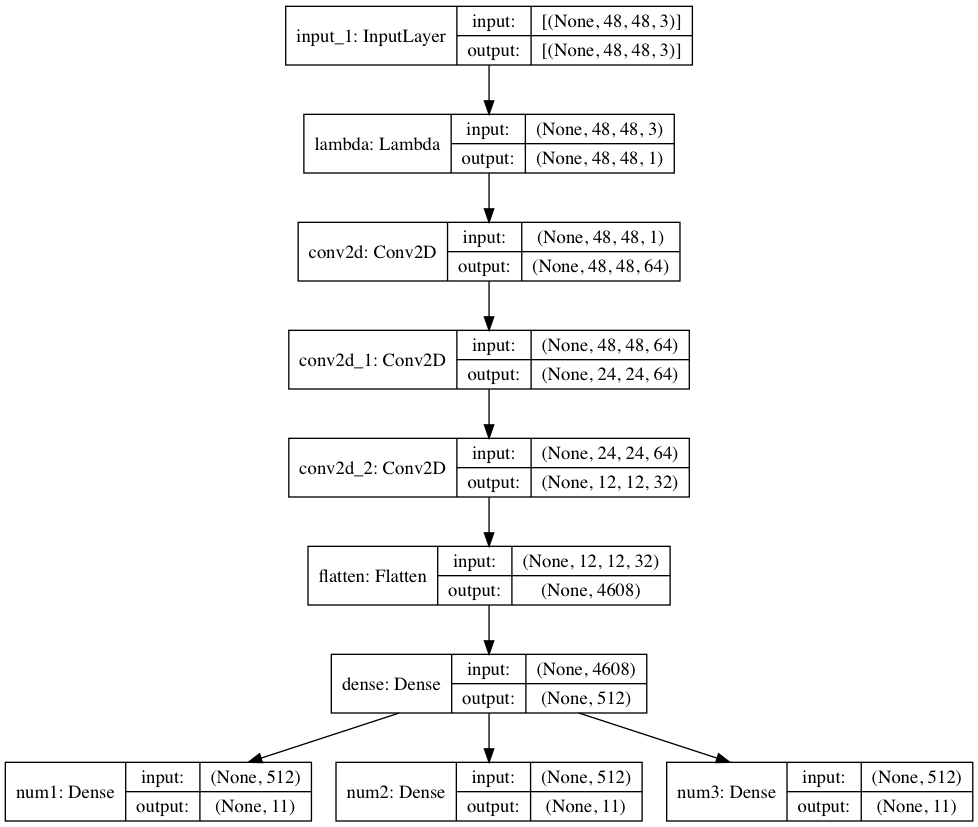

In [7]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 48, 48, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 64)   128         lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 64)   36928       conv2d[0][0]                     
______________________________________________________________________________________________

In [9]:
model.compile(optimizers.Adam(lr=0.001),loss=["categorical_crossentropy"]*3,metrics=["accuracy"])

In [10]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50
)

Epoch 1/50
105/105 [==============================] - 15s 146ms/step - loss: 5.7896 - num1_loss: 1.0998 - num2_loss: 2.3513 - num3_loss: 2.3385 - num1_acc: 0.4403 - num2_acc: 0.1224 - num3_acc: 0.1053 - val_loss: 6.0489 - val_num1_loss: 1.1222 - val_num2_loss: 2.5839 - val_num3_loss: 2.3427 - val_num1_acc: 0.3938 - val_num2_acc: 0.0661 - val_num3_acc: 0.1241
Epoch 2/50
105/105 [==============================] - 15s 142ms/step - loss: 5.6295 - num1_loss: 0.9793 - num2_loss: 2.3284 - num3_loss: 2.3218 - num1_acc: 0.5336 - num2_acc: 0.1287 - num3_acc: 0.1074 - val_loss: 5.9823 - val_num1_loss: 1.0135 - val_num2_loss: 2.5871 - val_num3_loss: 2.3817 - val_num1_acc: 0.4964 - val_num2_acc: 0.1170 - val_num3_acc: 0.1232
Epoch 3/50
105/105 [==============================] - 15s 145ms/step - loss: 5.3088 - num1_loss: 0.7705 - num2_loss: 2.2572 - num3_loss: 2.2811 - num1_acc: 0.6737 - num2_acc: 0.1713 - num3_acc: 0.1398 - val_loss: 5.9229 - val_num1_loss: 0.9350 - val_num2_loss: 2.6294 - val_num3

KeyboardInterrupt: 